# Cargue y preentrenamiento de datos

In [1]:
Etiquetas_Nombres = ['Basket', 'Campo_Futbol', 'Cancha_Multiple', 'Parque', 'Tenis']

In [2]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def cargar_imagenes_con_etiquetas(ruta_dataset):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path)
                    imagenes.append(np.array(img)) 
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

def obtener_tamanios_por_etiqueta(imagenes, etiquetas):
    tamanios_por_etiqueta = {}
    for img, etiqueta in zip(imagenes, etiquetas):
        tamanio = img.shape[:2]
        if etiqueta not in tamanios_por_etiqueta:
            tamanios_por_etiqueta[etiqueta] = set()
        tamanios_por_etiqueta[etiqueta].add(tamanio)
    return tamanios_por_etiqueta

def redimensionar_imagenes(imagenes, nuevo_tamanio):
    imagenes_redimensionadas = []
    for img in imagenes:
        img_pil = Image.fromarray(img)
        img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)
        imagenes_redimensionadas.append(np.array(img_redimensionada))
    return imagenes_redimensionadas

def verificar_tamanio(imagenes):
    tamanio_referencia = None
    for img in imagenes:
        if tamanio_referencia is None:
            tamanio_referencia = img.shape[:2]
        else:
            if img.shape[:2] != tamanio_referencia:
                return False
    return True

def normalizar_imagenes(imagenes):
    imagenes_array = np.array(imagenes)
    imagenes_normalizadas = imagenes_array / 255.0
    media = np.mean(imagenes_normalizadas, axis=(0, 1, 2))
    imagenes_normalizadas -= media
    return imagenes_normalizadas

#********************************************************************************************************

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Propio'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Obtener tamaños por etiqueta antes de redimensionar
tamanios_por_etiqueta = obtener_tamanios_por_etiqueta(imagenes, etiquetas)

tamanios_por_etiqueta


#********************************************************************************************************

nuevo_tamanio = (256, 256)
imagenes_redimensionadas = redimensionar_imagenes(imagenes, nuevo_tamanio)

if verificar_tamanio(imagenes_redimensionadas):
    print("Todas las imágenes tienen el mismo tamaño.")
else:
    print("Las imágenes tienen diferentes tamaños.")
    
imagenes_normalizadas = normalizar_imagenes(imagenes_redimensionadas)

#********************************************************************************************************

# Codificar las etiquetas
codificacion = {'Basket': 0, 'Campo_Futbol': 1, 'Cancha_Multiple': 2, 'Parque': 3, 'Tenis': 4}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes_normalizadas, etiquetas_codificadas, test_size=0.2, random_state=42)

# Aplanar las imágenes para el sobremuestreo
n_samples, height, width, channels = X_train.shape
X_train_2d = X_train.reshape((n_samples, -1))

# Mostrar la distribución de clases antes del balanceo
unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento antes del balanceo:")
print(dict(zip(unique, counts)))

#********************************************************************************************************

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original
X_train_res = X_train_res_2d.reshape((-1, height, width, channels))

# Mostrar la distribución de clases después del balanceo
unique_res, counts_res = np.unique(y_train_res, return_counts=True)
print("Distribución de clases en el conjunto de entrenamiento después del balanceo:")
print(dict(zip(unique_res, counts_res)))

#********************************************************************************************************

# Imprimir el tamaño de los conjuntos de entrenamiento y prueba
print("Número de ejemplos de entrenamiento antes del balanceo:", len(X_train))
print("Número de ejemplos de entrenamiento después del balanceo:", len(X_train_res))
print("Número de ejemplos de prueba:", len(X_test))


C:\Users\nicol\AppData\Local\Temp\ipykernel_19284\453095598.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_redimensionada = img_pil.resize(nuevo_tamanio, Image.ANTIALIAS)


Todas las imágenes tienen el mismo tamaño.
Distribución de clases en el conjunto de entrenamiento antes del balanceo:
{0: 284, 1: 285, 2: 271, 3: 260, 4: 264}
Distribución de clases en el conjunto de entrenamiento después del balanceo:
{0: 285, 1: 285, 2: 285, 3: 285, 4: 285}
Número de ejemplos de entrenamiento antes del balanceo: 1364
Número de ejemplos de entrenamiento después del balanceo: 1425
Número de ejemplos de prueba: 341


# Entrenamiento modelo customizado

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un modelo secuencial
modelo = Sequential()

# Agregar capas al modelo
modelo.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Conv2D(64, (3, 3), activation='relu'))
modelo.add(MaxPooling2D((2, 2)))
modelo.add(Flatten())
modelo.add(Dense(64, activation='relu'))
modelo.add(Dense(5, activation='softmax'))

# Compilar el modelo
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Mostrar un resumen del modelo
modelo.summary()

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping para detener el entrenamiento si la métrica no mejora
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Entrenar el modelo
historial_entrenamiento = modelo.fit(X_train_res, y_train_res, epochs=10, validation_data=(X_train_res, y_train_res))

# Predecir las etiquetas para el conjunto de prueba
y_pred_prob = modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)



c:\Users\nicol\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    15,745,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,805 (60.14 MB)

 Trainable params: 15,764,805 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 922ms/step - accuracy: 0.2788 - loss: 3.2901 - val_accuracy: 0.4821 - val_loss: 1.1778
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 940ms/step - accuracy: 0.5536 - loss: 1.0910 - val_accuracy: 0.6688 - val_loss: 0.8480
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 948ms/step - accuracy: 0.7012 - loss: 0.8189 - val_accuracy: 0.7705 - val_loss: 0.6346
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 966ms/step - accuracy: 0.7943 - loss: 0.6029 - val_accuracy: 0.8996 - val_loss: 0.3817
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 916ms/step - accuracy: 0.8930 - loss: 0.3376 - val_accuracy: 0.9340 - val_loss: 0.2258
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 971ms/step - accuracy: 0.9605 - loss: 0.1728 - val_accuracy: 0.9958 - val_loss: 0.0460
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 937ms/step - accuracy: 0.9964 - loss: 0.0411 - val_accuracy: 0.9993 - val_loss: 0.0174
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 922ms/step - accuracy: 0.9988 - loss: 0.0157 - val_accu

Precision: 0.6808944646140355
Recall: 0.6598240469208211
F1 Score: 0.6629721849972399
Accuracy: 0.6598240469208211
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.51      0.39      0.44        74
   Campo_Futbol       0.89      0.83      0.86        84
Cancha_Multiple       0.42      0.65      0.51        57
         Parque       0.78      0.79      0.79        68
          Tenis       0.74      0.60      0.67        58

       accuracy                           0.66       341
      macro avg       0.67      0.65      0.65       341
   weighted avg       0.68      0.66      0.66       341



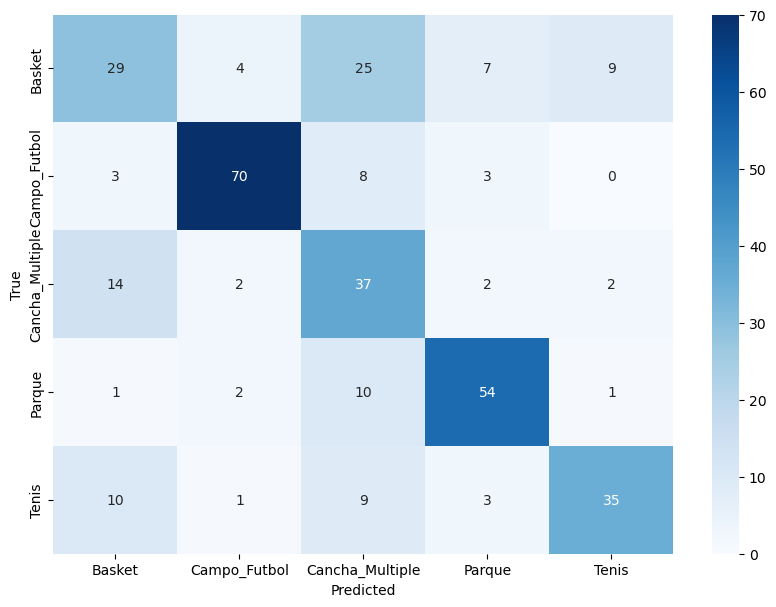

In [4]:
# Calcular la precisión, recall, f1 score y accuracy
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [5]:
# Supongamos que `model` es tu modelo entrenado
modelo.save('C:/Users/nicol/Desktop/Modelos/Propio/Propio_Custom.h5')

# Entrenamiento con VGG16

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo VGG16 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  

#******************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)
#******************************************************************************************




Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.3073 - loss: 2.7498 - val_accuracy: 0.5220 - val_loss: 1.1970 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - accuracy: 0.4510 - loss: 1.1961 - val_accuracy: 0.6657 - val_loss: 0.9391 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.5266 - loss: 1.0696 - val_accuracy: 0.6686 - val_loss: 0.9065 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.5673 - loss: 0.9706 - val_accuracy: 0.7185 - val_loss: 0.8508 - learning_rate: 9.0484e-04
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.6063 - loss: 0.9158 - val_accuracy: 0.7302 - val_loss: 0.7994 - learning_rate: 8.1873e-04
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 165s 4s/step - accuracy: 0.6261 - loss: 0.8419 - val_accuracy: 0.7155 - val_loss: 0.7410 - learning_rate: 7.4082e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.6470 - loss: 0.82

11/11 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step
Precision: 0.7959670506392672
Recall: 0.7741935483870968
F1 Score: 0.7666583722260438
Accuracy: 0.7741935483870968
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.72      0.38      0.50        74
   Campo_Futbol       0.99      0.88      0.93        84
Cancha_Multiple       0.52      0.82      0.64        57
         Parque       0.89      0.99      0.94        68
          Tenis       0.77      0.83      0.80        58

       accuracy                           0.77       341
      macro avg       0.78      0.78      0.76       341
   weighted avg       0.80      0.77      0.77       341



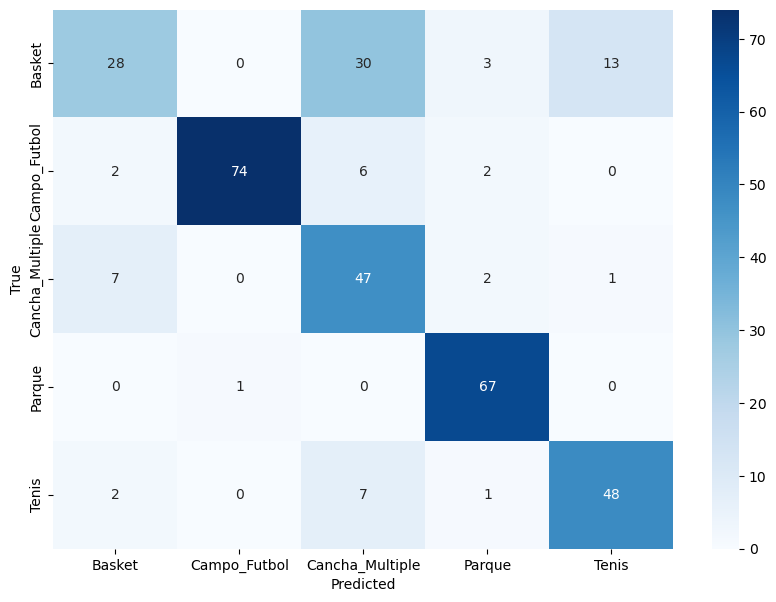

In [7]:
# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [8]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/Propio/Propio_VGG16.h5')

# Modelo Preentrenado Xception con ImageNet

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np

# Función para reducir el learning rate en cada época
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return lr * np.exp(-0.1)

# Crear el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=3,          # Número de épocas sin mejora para detener el entrenamiento
    verbose=1,           # Muestra mensajes en la salida estándar
    restore_best_weights=True  # Restaurar los pesos del modelo en su mejor punto
)

# Crear el callback LearningRateScheduler
lr_scheduler = LearningRateScheduler(scheduler)

# Cargar el modelo Xception 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas superiores
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)  

#*********************************************************************************************

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con los callbacks
model.fit(
    X_train_res, 
    y_train_res, 
    epochs=10, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]  # Agregar los callbacks aquí
)

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.3729 - loss: 6.3784 - val_accuracy: 0.5748 - val_loss: 1.0679 - learning_rate: 0.0010
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.4711 - loss: 1.1712 - val_accuracy: 0.6276 - val_loss: 0.9189 - learning_rate: 0.0010
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.5032 - loss: 1.0860 - val_accuracy: 0.6276 - val_loss: 0.9269 - learning_rate: 0.0010
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.5716 - loss: 0.9480 - val_accuracy: 0.6452 - val_loss: 0.8934 - learning_rate: 9.0484e-04
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.6332 - loss: 0.8927 - val_accuracy: 0.6628 - val_loss: 0.8545 - learning_rate: 8.1873e-04
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.6466 - loss: 0.8584 - val_accuracy: 0.7390 - val_loss: 0.7287 - learning_rate: 7.4082e-04
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.6764 - loss: 0.71

11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Precision: 0.7341019648968192
Recall: 0.7214076246334311
F1 Score: 0.7253687506951805
Accuracy: 0.7214076246334311
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.54      0.66      0.60        74
   Campo_Futbol       0.90      0.88      0.89        84
Cancha_Multiple       0.44      0.42      0.43        57
         Parque       0.82      0.79      0.81        68
          Tenis       0.92      0.78      0.84        58

       accuracy                           0.72       341
      macro avg       0.73      0.71      0.71       341
   weighted avg       0.73      0.72      0.73       341



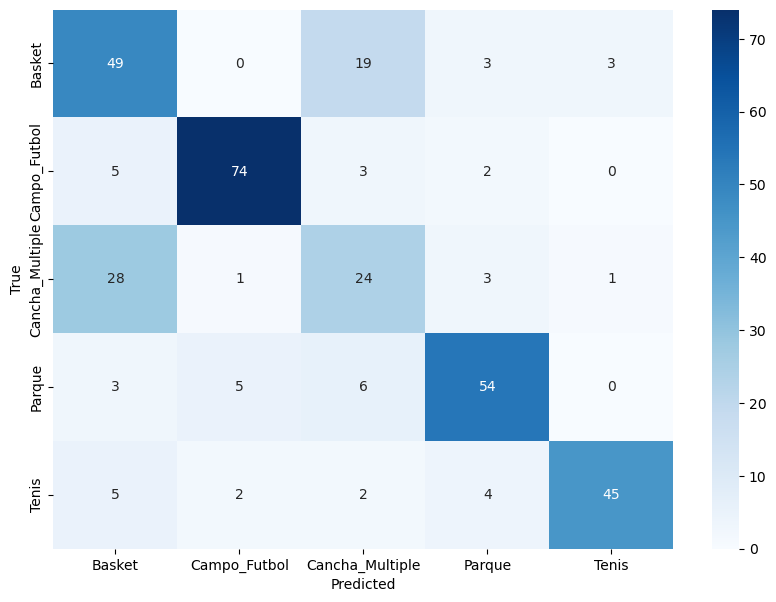

In [7]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar el modelo
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calcular las métricas
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names= Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres, yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [8]:
# Supongamos que `model` es tu modelo entrenado
model.save('C:/Users/nicol/Desktop/Modelos/Propio/Propio_Xception.h5')

# Entrenamiento con MobileNet Preentrenado con Imagenet

In [10]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Definir las etiquetas
Etiquetas_Nombres = ['Basket', 'Campo_Futbol', 'Cancha_Multiple', 'Parque', 'Tenis']

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Propio'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'Basket': 0, 'Campo_Futbol': 1, 'Cancha_Multiple': 2, 'Parque': 3, 'Tenis': 4}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo MobileNet preentrenado
model = models.mobilenet_v2(pretrained=True)

# Reemplazar la última capa del modelo para adaptarse a nuestro número de clases (5 en este caso)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.6314512011077669
Validation Loss: 0.4084256602959199
Epoch 2, Loss: 0.26343983097208873
Validation Loss: 0.3412130393765189
Epoch 3, Loss: 0.19595439790023697
Validation Loss: 0.21060432222756473
Epoch 4, Loss: 0.09447148092505005
Validation Loss: 0.14407397891310128
Epoch 5, Loss: 0.04281028841311733
Validation Loss: 0.1281728535382585
Epoch 6, Loss: 0.03980192723684013
Validation Loss: 0.11562546376477588
Epoch 7, Loss: 0.02358862326687409
Validation Loss: 0.11757765917784789
Epoch 8, Loss: 0.02210291831029786
Validation Loss: 0.11923098682679913
Epoch 9, Loss: 0.023825942815488412
Validation Loss: 0.14024652557616885
Early stopping triggered


Precision: 0.9609100273075917
Recall: 0.9589442815249267
F1 Score: 0.9589451616765013
Accuracy: 0.9589442815249267
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.89      0.99      0.94        74
   Campo_Futbol       1.00      0.93      0.96        84
Cancha_Multiple       0.93      0.88      0.90        57
         Parque       0.99      1.00      0.99        68
          Tenis       1.00      1.00      1.00        58

       accuracy                           0.96       341
      macro avg       0.96      0.96      0.96       341
   weighted avg       0.96      0.96      0.96       341



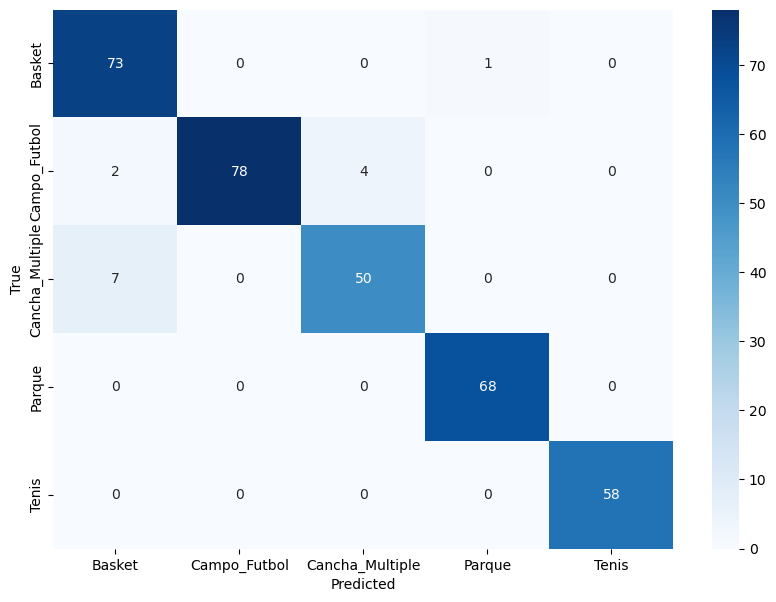

In [11]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [12]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/Propio/Propio_mobileNET.pth')

# Entrenamiento con Resnet18 Preentrenado con Imagenet

In [14]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Definir las etiquetas
Etiquetas_Nombres = ['Basket', 'Campo_Futbol', 'Cancha_Multiple', 'Parque', 'Tenis']

# Función para cargar imágenes y etiquetas
def cargar_imagenes_con_etiquetas(ruta_dataset, nuevo_tamanio=(256, 256)):
    imagenes = []
    etiquetas = []
    
    for etiqueta in os.listdir(ruta_dataset):
        carpeta = os.path.join(ruta_dataset, etiqueta)
        if os.path.isdir(carpeta):
            for archivo in os.listdir(carpeta):
                if archivo.endswith('.tif') or archivo.endswith('.png') or archivo.endswith('.jpg'):
                    img_path = os.path.join(carpeta, archivo)
                    img = Image.open(img_path).convert('RGB')  # Asegurarse de que todas las imágenes estén en RGB
                    img = img.resize(nuevo_tamanio)  # Redimensionar para garantizar que todas tengan el mismo tamaño
                    imagenes.append(np.array(img))  # Convertir a numpy array
                    etiquetas.append(etiqueta)
    
    return imagenes, etiquetas

# Cargar y procesar las imágenes
ruta_dataset = 'C:/Users/nicol/Desktop/Universidad/Dataset_Utiles/Propio'
imagenes, etiquetas = cargar_imagenes_con_etiquetas(ruta_dataset)

# Codificar las etiquetas
codificacion = {'Basket': 0, 'Campo_Futbol': 1, 'Cancha_Multiple': 2, 'Parque': 3, 'Tenis': 4}
etiquetas_codificadas = np.array([codificacion[etiqueta] for etiqueta in etiquetas])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imagenes, etiquetas_codificadas, test_size=0.2, random_state=42)

# Convertir las imágenes a arrays de numpy
X_train_np = np.array(X_train)
height, width, channels = X_train_np.shape[1:]  # Obtener las dimensiones de las imágenes

# Aplanar las imágenes para el sobremuestreo
X_train_2d = X_train_np.reshape(len(X_train_np), -1)

# Aplicar sobremuestreo aleatorio
ros = RandomOverSampler(random_state=42)
X_train_res_2d, y_train_res = ros.fit_resample(X_train_2d, y_train)

# Reconstruir las imágenes a su forma original después del sobremuestreo
X_train_res = X_train_res_2d.reshape(-1, height, width, channels)

# Definir las transformaciones con normalización y redimensionamiento
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convertir de numpy array a PIL image
    transforms.Resize((256, 256)),  # Redimensionar la imagen
    transforms.ToTensor(),  # Convertir de PIL a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Custom Dataset con transformaciones
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)  # Aplicar transformaciones
        return image, label

# Crear los datasets de entrenamiento y prueba
train_dataset = CustomDataset(X_train_res, y_train_res.astype(int), transform=transform)
test_dataset = CustomDataset(X_test, y_test.astype(int), transform=transform)

# Crear DataLoaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Entrenamiento y evaluación del modelo
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Cargar el modelo ResNet18 preentrenado
model = models.resnet18(pretrained=True)

# Reemplazar la última capa (fully connected layer) de ResNet18 para adaptarse a nuestro número de clases (5 en este caso)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Cambiar el scheduler a StepLR para reducir cada 3 épocas
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Early stopping variables
best_loss = np.Inf
patience = 3
epochs_no_improve = 0
early_stop = False

# Entrenamiento del modelo
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    
    # Validación
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(testloader)
    print(f'Validation Loss: {val_loss}')
    
    scheduler.step()
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print('Early stopping triggered')
        early_stop = True
        break

    if early_stop:
        break


c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicol\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.7055717872248756
Validation Loss: 0.6525233929807489
Epoch 2, Loss: 0.3332471489906311
Validation Loss: 0.3356074636632746
Epoch 3, Loss: 0.14907937492761347
Validation Loss: 0.37476760284467175
Epoch 4, Loss: 0.06861378538111845
Validation Loss: 0.18005281381986357
Epoch 5, Loss: 0.029298820387985973
Validation Loss: 0.1587976576252417
Epoch 6, Loss: 0.01774715235353344
Validation Loss: 0.16108897954902865
Epoch 7, Loss: 0.014620832208957936
Validation Loss: 0.16291827031157233
Epoch 8, Loss: 0.016052665763224165
Validation Loss: 0.15621050726622343
Epoch 9, Loss: 0.011515857538001405
Validation Loss: 0.15182733391834932
Epoch 10, Loss: 0.01170082031749189
Validation Loss: 0.1606385839933699
Epoch 11, Loss: 0.010302882160370548
Validation Loss: 0.1567521784454584
Epoch 12, Loss: 0.017919572277201548
Validation Loss: 0.15715090879662472
Early stopping triggered


Precision: 0.9603697506012068
Recall: 0.9589442815249267
F1 Score: 0.9588919752067802
Accuracy: 0.9589442815249267
Classification Report:
                 precision    recall  f1-score   support

         Basket       0.90      0.99      0.94        74
   Campo_Futbol       1.00      0.94      0.97        84
Cancha_Multiple       0.93      0.88      0.90        57
         Parque       0.99      0.99      0.99        68
          Tenis       0.98      1.00      0.99        58

       accuracy                           0.96       341
      macro avg       0.96      0.96      0.96       341
   weighted avg       0.96      0.96      0.96       341



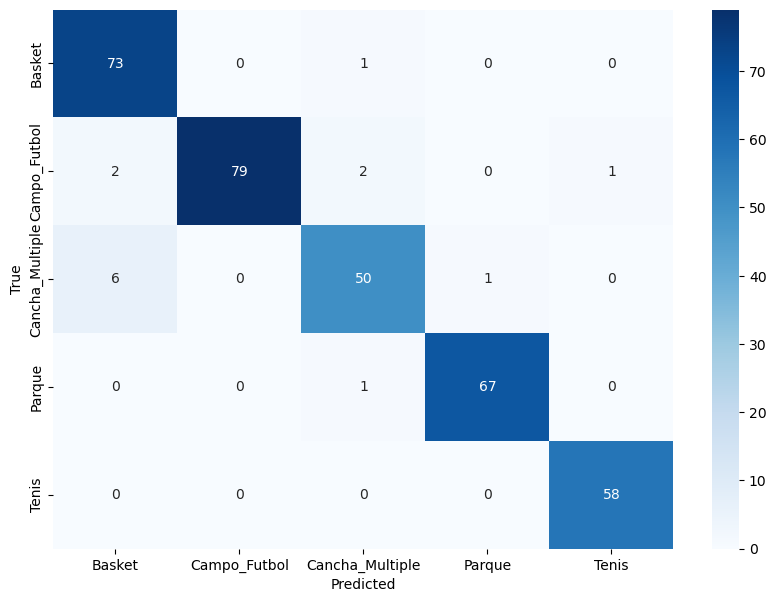

In [15]:

# Evaluación del modelo
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calcular las métricas
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

# Obtener un informe detallado de clasificación
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=Etiquetas_Nombres))

# Matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=Etiquetas_Nombres,
            yticklabels=Etiquetas_Nombres)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [17]:
# Guardar el modelo completo
torch.save(model, 'C:/Users/nicol/Desktop/Modelos/Propio/Propio_ResNET18.pth')